<a href="https://colab.research.google.com/github/spour/DeepExplain/blob/master/deeplift_tf2_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install deeplift
!pip install simdna
import simdna.synthetic as synthetic
import gzip
data_filename = "sequences.simdata.gz"
import tensorflow as tf
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = [x.decode("utf-8").rstrip("\n") for x in test_ids_fh]
data = synthetic.read_simdata_file(data_filename, ids_to_load=ids_to_load)

import numpy as np

#this is set up for 1d convolutions where examples
#have dimensions (len, num_channels)
#the channel axis is the axis for one-hot encoding.
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
onehot_data = np.array([one_hot_encode_along_channel_axis(seq) for seq in data.sequences])


In [2]:
!wget https://raw.githubusercontent.com/kundajelab/deeplift/d95d41d/examples/genomics/grab_model_and_data.sh
!chmod a+x grab_model_and_data.sh
!./grab_model_and_data.sh
keras_model_weights = "keras2_conv1d_record_5_model_PQzyq_modelWeights.h5"
keras_model_json = "keras2_conv1d_record_5_model_PQzyq_modelJson.json"

from keras.models import model_from_json
keras_model = model_from_json(open(keras_model_json).read())
keras_model.load_weights(keras_model_weights)
import deeplift.conversion.kerasapi_conversion as kc
kc.convert_model_from_saved_files(
        h5_file=keras_model_weights,
        json_file=keras_model_json)

--2021-08-19 20:57:47--  https://raw.githubusercontent.com/kundajelab/deeplift/d95d41d/examples/genomics/grab_model_and_data.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1145 (1.1K) [text/plain]
Saving to: ‘grab_model_and_data.sh.31’

grab_model_and_data 100%[===================>]   1.12K  --.-KB/s    in 0s      

2021-08-19 20:57:47 (60.0 MB/s) - ‘grab_model_and_data.sh.31’ saved [1145/1145]

File sequences.simdata.gz exists already
File keras2_conv1d_record_5_model_PQzyq_modelJson.json exists already
File keras2_record_5_model_PQzyq_modelWeights.h5 exists already
File test.txt.gz exists already
nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault
For layer 1 the preceding linear layer is 0 of type Conv1D;
In accordance with nonlinear_mxts_mode=Dee

In [3]:
# import tensorflow.executing_eagerly as

In [4]:
from deeplift.layers import NonlinearMxtsMode
import deeplift.conversion.kerasapi_conversion as kc
from collections import OrderedDict

method_to_model = OrderedDict()
for method_name, nonlinear_mxts_mode in [
    #The genomics default = rescale on conv layers, revealcance on fully-connected
    ('rescale_conv_revealcancel_fc', NonlinearMxtsMode.DeepLIFT_GenomicsDefault),
    ('rescale_all_layers', NonlinearMxtsMode.Rescale),
    ('revealcancel_all_layers', NonlinearMxtsMode.RevealCancel),
    ('grad_times_inp', NonlinearMxtsMode.Gradient),
    ('guided_backprop', NonlinearMxtsMode.GuidedBackprop)]:
    method_to_model[method_name] = kc.convert_model_from_saved_files(
        h5_file=keras_model_weights,
        json_file=keras_model_json,
        nonlinear_mxts_mode=nonlinear_mxts_mode)

nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault
For layer 1 the preceding linear layer is 0 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 3 the preceding linear layer is 2 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 7 the preceding linear layer is 6 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
For layer 10 the preceding linear layer is 9 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
nonlinear_mxts_mode is set to: Rescale
nonlinear_mxts_mode is set to: RevealCancel
nonlinear_mxts_mode is set to: Gradient
nonlinear_mxts_mode is set to: GuidedBackprop


In [5]:
import deeplift

In [6]:
from deeplift.util import compile_func

# tensorflow.compat.v1.enable_eager_execution()
model_to_test = method_to_model['rescale_conv_revealcancel_fc']

deeplift_prediction_func = compile_func([model_to_test.get_layers()[0].get_activation_vars()],
                                        model_to_test.get_layers()[-1].get_activation_vars())
original_model_predictions = keras_model.predict(onehot_data, batch_size=200)
converted_model_predictions = deeplift.util.run_function_in_batches(
                                input_data_list=[onehot_data],
                                func=deeplift_prediction_func,
                                batch_size=200,
                                progress_update=None)
print("maximum difference in predictions:",np.max(np.array(converted_model_predictions)-np.array(original_model_predictions)))
assert np.max(np.array(converted_model_predictions)-np.array(original_model_predictions)) < 10**-5
predictions = converted_model_predictions

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


maximum difference in predictions: 0.0


In [7]:
print("Compiling scoring functions")
method_to_scoring_func = OrderedDict()
for method,model in method_to_model.items():
    print("Compiling scoring function for: "+method)
    method_to_scoring_func[method] = model.get_target_contribs_func(find_scores_layer_idx=0,
                                                                    target_layer_idx=-2)
    
#To get a function that just gives the gradients, we use the multipliers of the Gradient model
gradient_func = method_to_model['grad_times_inp'].get_target_multipliers_func(find_scores_layer_idx=0,
                                                                              target_layer_idx=-2)
print("Compiling integrated gradients scoring functions")
integrated_gradients10_func = deeplift.util.get_integrated_gradients_function(
    gradient_computation_function = gradient_func,
    num_intervals=10)
method_to_scoring_func['integrated_gradients10'] = integrated_gradients10_func

Compiling scoring functions
Compiling scoring function for: rescale_conv_revealcancel_fc
Compiling scoring function for: rescale_all_layers
Compiling scoring function for: revealcancel_all_layers
Compiling scoring function for: grad_times_inp
Compiling scoring function for: guided_backprop
Compiling integrated gradients scoring functions


In [8]:
background = OrderedDict([('A', 0.3), ('C', 0.2), ('G', 0.2), ('T', 0.3)])

from collections import OrderedDict
method_to_task_to_scores = OrderedDict()
for method_name, score_func in method_to_scoring_func.items():
    print("on method",method_name)
    method_to_task_to_scores[method_name] = OrderedDict()
    for task_idx in [0,1,2]:
        scores = np.array(score_func(
                    task_idx=task_idx,
                    input_data_list=[onehot_data],
                    input_references_list=[
                     np.array([background['A'],
                               background['C'],
                               background['G'],
                               background['T']])[None,None,:]],
                    batch_size=200,
                    progress_update=None))
        assert scores.shape[2]==4
        #The sum over the ACGT axis in the code below is important! Recall that DeepLIFT
        # assigns contributions based on difference-from-reference; if
        # a position is [1,0,0,0] (i.e. 'A') in the actual sequence and [0.3, 0.2, 0.2, 0.3]
        # in the reference, importance will be assigned to the difference (1-0.3)
        # in the 'A' channel, (0-0.2) in the 'C' channel,
        # (0-0.2) in the G channel, and (0-0.3) in the T channel. You want to take the importance
        # on all four channels and sum them up, so that at visualization-time you can project the
        # total importance over all four channels onto the base that is actually present (i.e. the 'A'). If you
        # don't do this, your visualization will look very confusing as multiple bases will be highlighted at
        # every position and you won't know which base is the one that is actually present in the sequence!
        scores = np.sum(scores, axis=2)
        method_to_task_to_scores[method_name][task_idx] = scores

on method rescale_conv_revealcancel_fc
on method rescale_all_layers
on method revealcancel_all_layers
on method grad_times_inp
on method guided_backprop
on method integrated_gradients10


In [9]:
from deeplift.util import get_shuffle_seq_ref_function
#from deeplift.util import randomly_shuffle_seq
from deeplift.dinuc_shuffle import dinuc_shuffle #function to do a dinucleotide shuffle

rescale_conv_revealcancel_fc_many_refs_func = get_shuffle_seq_ref_function(
    #score_computation_function is the original function to compute scores
    score_computation_function=method_to_scoring_func['rescale_conv_revealcancel_fc'],
    #shuffle_func is the function that shuffles the sequence
    #technically, given the background of this simulation, randomly_shuffle_seq
    #makes more sense. However, on real data, a dinuc shuffle is advisable due to
    #the strong bias against CG dinucleotides
    shuffle_func=dinuc_shuffle,
    one_hot_func=lambda x: np.array([one_hot_encode_along_channel_axis(seq) for seq in x]))

num_refs_per_seq=20 #number of references to generate per sequence
method_to_task_to_scores['rescale_conv_revealcancel_fc_multiref_'+str(num_refs_per_seq)] = OrderedDict()
scores_without_sum_applied = rescale_conv_revealcancel_fc_many_refs_func(
            task_idx=[0,1,2], #can provide a list of tasks; references will be reused for each
            #Providing a single integeter for task_idx works too and would return a numpy array rather
            # than a list of numpy arrays
            input_data_sequences=data.sequences,
            num_refs_per_seq=num_refs_per_seq,
            batch_size=200,
            progress_update=1000)
for task_idx, scores in enumerate(scores_without_sum_applied):
    #The sum over the ACGT axis in the code below is important! Recall that DeepLIFT
    # assigns contributions based on difference-from-reference; if
    # a position is [1,0,0,0] (i.e. 'A') in the actual sequence and [0, 1, 0, 0]
    # in the reference, importance will be assigned to the difference (1-0)
    # in the 'A' channel, and (0-1) in the 'C' channel. You want to take the importance
    # on all channels and sum them up, so that at visualization-time you can project the
    # total importance over all four channels onto the base that is actually present (i.e. the 'A'). If you
    # don't do this, your visualization will look very confusing as multiple bases will be highlighted at
    # every position and you won't know which base is the one that is actually present in the sequence!
    method_to_task_to_scores['rescale_conv_revealcancel_fc_multiref_'+str(num_refs_per_seq)][task_idx] =\
        np.sum(scores,axis=2)

1000 reference seqs generated
2000 reference seqs generated
3000 reference seqs generated
4000 reference seqs generated
5000 reference seqs generated
6000 reference seqs generated
7000 reference seqs generated
8000 reference seqs generated
9000 reference seqs generated
10000 reference seqs generated
11000 reference seqs generated
12000 reference seqs generated
13000 reference seqs generated
14000 reference seqs generated
15000 reference seqs generated
16000 reference seqs generated
One hot encoding sequences...
One hot encoding done...
Done 0
Done 1000
Done 2000
Done 3000
Done 4000
Done 5000
Done 6000
Done 7000
Done 8000
Done 9000
Done 10000
Done 11000
Done 12000
Done 13000
Done 14000
Done 15000
Done 0
Done 1000
Done 2000
Done 3000
Done 4000
Done 5000
Done 6000
Done 7000
Done 8000
Done 9000
Done 10000
Done 11000
Done 12000
Done 13000
Done 14000
Done 15000
Done 0
Done 1000
Done 2000
Done 3000
Done 4000
Done 5000
Done 6000
Done 7000
Done 8000
Done 9000
Done 10000
Done 11000
Done 12000
Do

Scores for task 0 for example 731
grad_times_inp


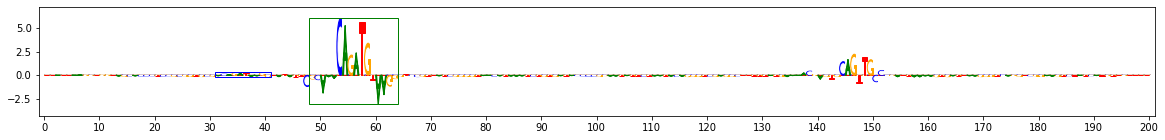

guided_backprop


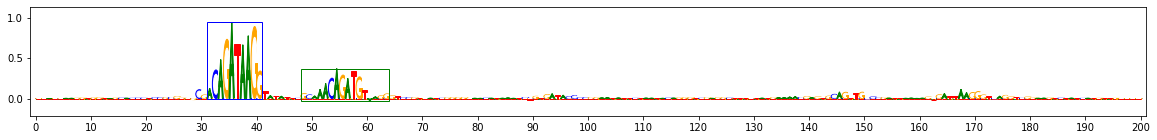

integrated_gradients10


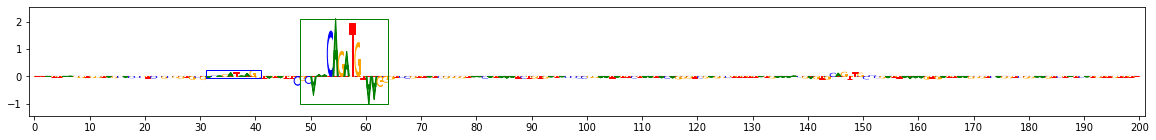

rescale_all_layers


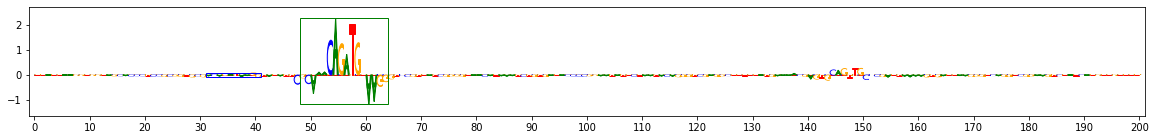

revealcancel_all_layers


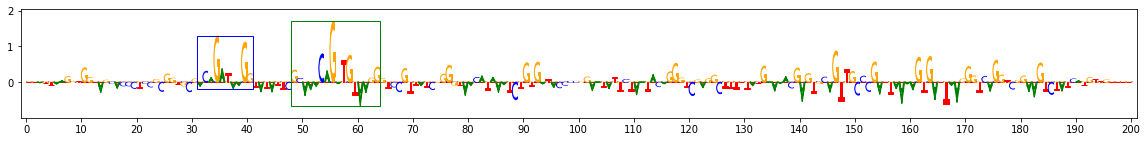

rescale_conv_revealcancel_fc


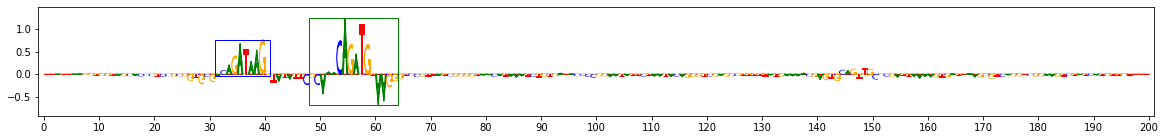

rescale_conv_revealcancel_fc_multiref_20


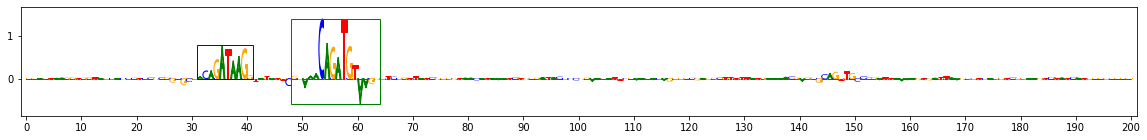

Scores for task 1 for example 197
grad_times_inp


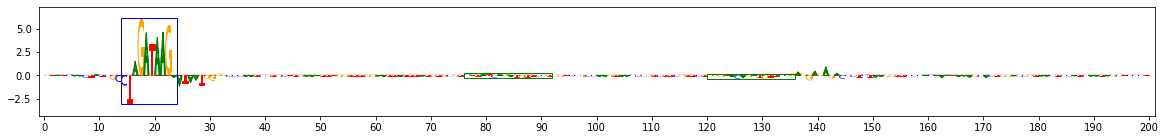

guided_backprop


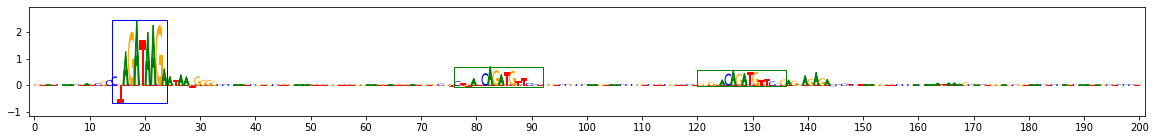

integrated_gradients10


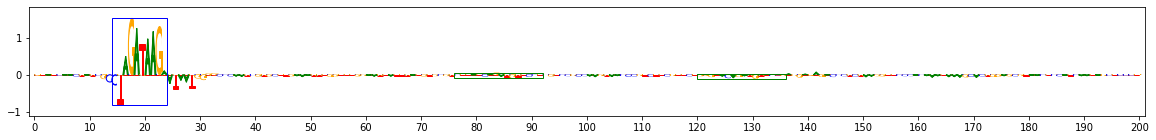

rescale_all_layers


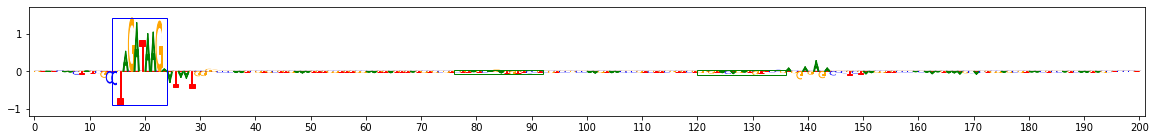

revealcancel_all_layers


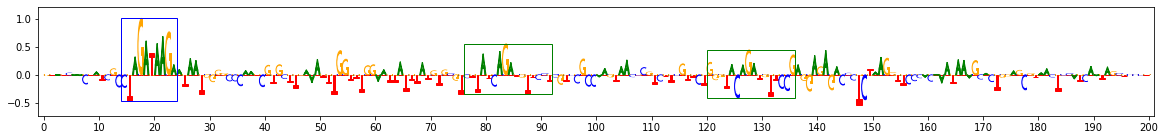

rescale_conv_revealcancel_fc


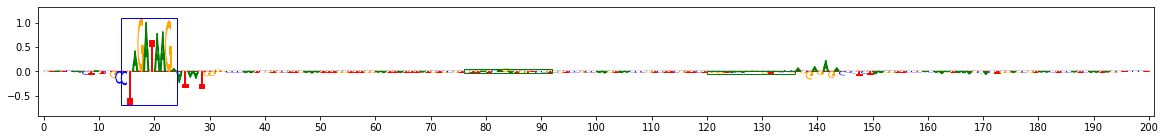

rescale_conv_revealcancel_fc_multiref_20


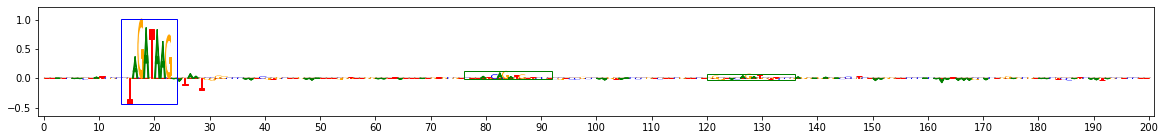

In [10]:
%matplotlib inline
from deeplift.visualization import viz_sequence

for task, idx in [(0,731), #illustrates failure of grad*inp, integrated grads, deeplift-rescale
                  (1,197)  #illustrates non-specific firing of guided backprop
                 ]:
    print("Scores for task",task,"for example",idx)
    for method_name in [
                        'grad_times_inp',
                        'guided_backprop',
                        'integrated_gradients10',
                        'rescale_all_layers', 'revealcancel_all_layers',
                        'rescale_conv_revealcancel_fc',
                        'rescale_conv_revealcancel_fc_multiref_'+str(num_refs_per_seq)
                        ]:
        scores = method_to_task_to_scores[method_name][task]
        scores_for_idx = scores[idx]
        original_onehot = onehot_data[idx]
        scores_for_idx = original_onehot*scores_for_idx[:,None]
        print(method_name)
        highlight = {'blue':[
                (embedding.startPos, embedding.startPos+len(embedding.what))
                for embedding in data.embeddings[idx] if 'GATA_disc1' in embedding.what.getDescription()],
                'green':[
                (embedding.startPos, embedding.startPos+len(embedding.what))
                for embedding in data.embeddings[idx] if 'TAL1_known1' in embedding.what.getDescription()]}
        viz_sequence.plot_weights(scores_for_idx, subticks_frequency=10, highlight=highlight)